# Who cares?  Drivers of engagement in International Development

With over a quarter of the world's population on Facebook, the platform has become an effective tool for enhancing communication and outreach strategies.  For international development organizations, increased engagement can help to raise awareness and mobilize financial and in-kind support for key issues that contribute to social and economic development.  How do international development organizations differ in their approach to engagement in terms of frequency of posts, topic of posts, and associated media?  What are effective strategies for enhancing engagement on Facebook as measured by likes, comments, and shares of posts?  Do the timing of posts and frequency of posts matter?  Does using videos and photos provide attention getting value?  What topics of coverage generates greater comments? Are users sensitive to content subjectivity or degree of positive content contained in messages?

## Data

This project uses the Facebook page data of key organizations in international development and their feeds over time that is available from Facebook's public graph API.  It provides some preliminary insights into the production of social media by these organizations and strategies that could be effective in enhancing Facebook follower engagement.  


In [1]:
import pandas as pd
import urllib.request as urlrequest
import json
import datetime
import csv
import time
import re
import numpy as np
#Natural language processing packages
import nltk
#nltk.download()
from textblob import TextBlob
import pickle

#this is to get access to twitter feeds
import tweepy

In [2]:
#Function accesses bare minimum data in Graph explorer
def getFacebookPageData(page_id, access_token):
    
    # construct the URL string
    base = "https://graph.facebook.com/v2.9"
    node = "/" + page_id
    parameters = "/?fields=about,engagement,fan_count,affiliation,company_overview,country_page_likes,talking_about_count,overall_star_rating,rating_count&access_token=%s" % access_token
    url = base + node + parameters
    
    #can use this to retrieve metadata information that is available
    #node = "/" + pageid + "/?metadata=1"
    
    # retrieve data
    req = urlrequest.Request(url)
    response = urlrequest.urlopen(req)
    data = json.loads(response.read())
    
    fan_count = data["fan_count"]
    talking_about_count = data["talking_about_count"]
    star_rating = '' if 'overall_star_rating' not in data.keys() else data["overall_star_rating"]
    
    return(fan_count,talking_about_count,star_rating)

In [3]:
app_id = '2026494927581067' # found at developer.facebook.com
app_secret = '8ca55671c30d485e2c882361e61a8405' # found at developer.facebook.com
access_token = app_id + "|" + app_secret

In [4]:
punctuation = ["'",'''"''',".",";","(",")",",",":","&","*","\\n","!",">","#","$","_"]
other_clean = ["b'","target=_blank>","</a>","fgm/e","*","-","/"]
uselesswords = ["about","after","based","before","being","between",
                "could","create","didnt"
                "files","first","following","function",
                "given","including",
                "looking","other","people","possible","question","remember"
                "series","service","several","short","should",
                "their","there","these","think","through","tried","trying",
                "using","where","which","without","while","would","years","seems"]

def repl(m):
    #print(m.group(1) + m.group(2))
    return(m.group(1) + m.group(2))

def clean_string(string):
    textstr = str.lower(str(string))
    textstr, nums = re.subn(r'http(.*?)(\s|$)',' ',textstr)
    #print("Number of http subs", nums)
    textstr, nums = re.subn(r'\\x\w\w',' ',textstr)
    #print("Number of \\xe2\\x80 subs", nums)
    #textstr, nums = re.subn(r'\\xc3\\\w{3}',' ',textstr)
    #print("Number of \xc3 subs", nums)
    textstr, nums = re.subn(r'\?','',textstr)
    #print("Number of ? removed", nums)
    #remove space from words that should be treated as one
    textstr, nums = re.subn(r'(human|united)\s(rights|nations)',repl,textstr)
    textstr = textstr.replace("human rights","humanrights")
    textstr = textstr.replace("united nations","unitednations")
    textstr = textstr.replace("un ","unitednations")
    #print("Number of concatenated", nums)
    for i in other_clean:
        textstr = textstr.replace(i," ")
    for i in punctuation:
        textstr = textstr.replace(i,"")
    for w in uselesswords:
        textstr = textstr.replace(w,"")
    return(textstr)

In [5]:
#Function for parsing message data
def split_strings(string):
    split_string = string.split(" ")
    split_string = [word for word in split_string if len(word) >= 5 or word in ["un","girl","boy","boys","imf"]]
    for w in uselesswords:
        try:
            split_string.remove(w)
        except ValueError:
            pass
    return split_string

In [6]:
#print(undata.head())
#Natural language processing can apply weights to each string with important words and see what gets most attention
def wordrank(data):
    term_weight = {}
    term_count = {}
    split_message = [split_strings(m) for m in data["clean_message"]]
    for i in range(0,len(data)):
        #print(split_message[i])
        for w in split_message[i]:
            if w in term_weight:
                term_weight[w] += data["num_likes"].iloc[i]
            else:
                term_weight[w] = data["num_likes"].iloc[i]
            if w in term_count:
                term_count[w] += 1
            else:
                term_count[w] = 1
    term_impact = {}
    for key, val in term_weight.items():
        term_impact[key] = round(term_weight[key]/term_count[key],1)
        #print(key, term_weight[key],term_count[key],term_impact[key])
    #should likewise weigh uniqueness
    return term_impact

In [7]:
import sys
from collections import Counter
import operator
import functools

subjects = {'aid_effectiveness' : ['aid effectiveness'],
            'climate_change' : ['climate change'],
            'corruption_governance' : ['corruption','corruption and transparency','governance'],
            'data_technology' : ['data and technology'],
            'education' : ['education'],
            'finance_investment' : ['finance','investment'],
            'gender' : ['gender'],
            'global_health' : ['global health'],
            'infrastructure' : ['infrastructure'],
            #'interntl_inst' : ['international institutions'],
            'migration' : ['human migration'],
            'povertyineqgrowth' : ['poverty','inequality and growth'],
            'intltrade' : ['international trade']
}


# Using simple categorization using the top 20 individual words and top 10 (bigram words) of each subject to cateogrize/tag
most_freq_nouns = {}
most_freq_bigrams = {}
for key,val in subjects.items():
    fname = 'C:\\JobApplications\\Facebook\\TrainSubjects\\'+key+'.csv'
    with open(fname, 'rb') as f:
        most_freq_nouns[key] = pickle.load(f)
    fname = 'C:\\JobApplications\\Facebook\\TrainSubjects\\'+key+'_bigrams.csv'
    with open(fname, 'rb') as f:
        most_freq_bigrams[key] = pickle.load(f)    

def tag_subject(text_counts, text_counts_bigrams):
    score_subject = {}
    for key, val in subjects.items():
        score_subject[key] = 0
        for word, wrdcnt in text_counts.items():
            if word in most_freq_nouns[key]:
                score_subject[key] += wrdcnt
        for word, wrdcnt in text_counts_bigrams.items():
            if word in most_freq_bigrams[key]:
                score_subject[key] += wrdcnt
    max_value = max(score_subject.values())
    if max_value > 0:
        max_keys = [k for k, v in score_subject.items() if v == max_value] # getting all keys containing the `maximum`
        #print(max_keys[0])
        return(max_keys[0])
    else:
        return('other')

#This will call all of the critical data given a pageid

def analyze_page(pageid,details=0):

    fan_count,talking_about_count,star_rating = getFacebookPageData(pageid, access_token)
    print("Fan page count: {}".format(fan_count))
    print("Talking about count: {}".format(talking_about_count))

    data = pd.read_csv(pageid + '_facebook_statuses.csv',encoding="utf-8",parse_dates=["status_published"])
    print("Dataset shape: {}".format(data.shape))
    data["publish_year"] = [row.year for row in data["status_published"]]
    data["publish_hour"] = [row.hour for row in data["status_published"]]
    #there are some with data that are way too early in terms of publication (so something is wrong with the data)
    data = data.loc[data["publish_year"]>=2006]
    
    data["publish_month"] = [row.month for row in data["status_published"]]
    print("Minimum year: {}".format(data["publish_year"].min()))
    data["clean_message"] = [clean_string(str(data['status_message'][i])+" "+str(data['status_description'][i])) for i in range(0,len(data))]  

    #note that we do not have to clean the data as precisely to extract subjects (more important for training data)
    text_counts = [Counter(str(message).split()) for message in data['clean_message']]
    #print(text_counts[0:20])
    #note that we do not have to clean the data as precisely to extract subjects (more important for training data)
    text_counts_bigrams = [Counter(list(nltk.bigrams(str(message).split()))) for message in data['clean_message']]
    data['tag_subject'] = [tag_subject(text_counts[i],text_counts_bigrams[i]) for i in range(0,len(data))]
    data = pd.concat([data, pd.get_dummies(data["tag_subject"])], axis=1)
    
    #Sentiment analysis (polarity ranges between -1/1 indicating positive or negative sentiment)
    #(subjectivity ranges between 0 to 1 indicating objective at 0 and subjective at 1)
    data["message_polarity"] = [TextBlob(str(row)).sentiment.polarity for row in data["status_message"]]
    data["message_subjectivity"] = [TextBlob(str(row)).sentiment.subjectivity for row in data["status_message"]]
    
    #Hours that have lapsed since last post
    data.sort_values("status_published",ascending=True,inplace=True)
    data["last_post"] = data["status_published"]-data["status_published"].shift(1)
    data["last_post"].fillna(0,inplace=True)
    data["last_post_hrs"] = [row.days*24 + row.seconds/3600 for row in data["last_post"]]
    
    #Create day of week where sunday is the firstday
    data["day_of_week"] = [row.weekday() for row in data["status_published"]]
    
    #Generate the number of posts in previous 24 hours
    data["rounded_hour"] = [row.replace(minute=0,second=0) for row in data["status_published"]]
    data["date"] = [datetime.datetime(row.year,row.month,row.day) for row in data["status_published"]]
    
    #Generate message length (approximate...)
    data["len_message"] = [len(split_strings(str(m))) for m in data["status_message"]]

    #Final additional variables used for summary statistics/regression analysis
    data['post'] = 1
    data["photo"] = data["status_type"] == "photo"
    data["video"] = data["status_type"] == "video"
    data["positive"] = data["message_polarity"] >= 0.1
    data["positive_polarity"] = data["positive"]*data["message_polarity"]
    data["neutral"] = np.abs(data["message_polarity"]) <= 0.1
    data["negative"] = data["message_polarity"] <= -0.1
    data["negative_polarity"] = (-1)*data["negative"]*data["message_polarity"]
    
    # Create an empty dataframe
    df = pd.DataFrame()
    # Extract important columns from the datetime variable
    df['datetime'] = data["status_published"]
    df[['num_likes','num_shares','num_comments']] = data[['num_likes','num_shares','num_comments']]
    df["post"] = 1    
    # Convert that column into a datetime datatype
    df['datetime'] = pd.to_datetime(df['datetime'])
    # Set the datetime column as the index
    df.index = df['datetime'] 
    
    #Create a column of num posts per hour
    temp1 = df.resample('H').sum()
    temp1.fillna(0,inplace=True)
    xcol1 = []
    xcol2 = []
    for v in ["post"]:
        temp1["num_"+v+"_L24hrs"] = temp1[v].rolling(window=24).sum().shift(1)
        xcol1.append("num_"+v+"_L24hrs")
    temp1 = temp1[xcol1]
    temp1.reset_index(inplace=True)
    temp1["rounded_hour"] = temp1["datetime"]
    temp2 = df.resample('H').mean()
    for v in ["num_likes","num_shares","num_comments"]:
        temp2["avg_"+v+"_L24hrs"] = temp2[v].rolling(window=24).sum().shift(1)
        xcol2.append("avg_"+v+"_L24hrs")
    temp2 = temp2[xcol2]
    temp2.reset_index(inplace=True)
    temp2["rounded_hour"] = temp2["datetime"]
    #print(temp1.head())
    data = pd.merge(data,temp1,how="left",on="rounded_hour")
    data = pd.merge(data,temp2,how="left",on="rounded_hour")    
    
    #Create a column of num posts per day
    temp1 = df.resample('D').sum()
    temp1.fillna(0,inplace=True)
    for v in ["post"]:
        temp1["num_"+v+"_L7days"] = temp1[v].rolling(window=7).sum().shift(1)
        temp1["num_"+v+"_L30days"] = temp1[v].rolling(window=30).sum().shift(1)
    temp1.reset_index(inplace=True)
    temp1["date"] = temp1["datetime"]
    temp2 = df.resample('D').mean()
    for v in ["num_likes","num_shares","num_comments"]:
        temp2["avg_"+v+"_L7days"] = temp2[v].rolling(window=7).sum().shift(1)   
        temp2["avg_"+v+"_L30days"] = temp2[v].rolling(window=30).sum().shift(1)
    temp2.reset_index(inplace=True)
    temp2["date"] = temp2["datetime"]
    data = pd.merge(data,temp1,how="left",on="date")
    data = pd.merge(data,temp2,how="left",on="date")       
    
    #message data is now pretty clean we should be able to parse the data and store it in different words to start analyzing categories
    #to focus discussion we will first look at categories that are one standard deviations above the mean in (likes, comments, shares)
    descr = data.describe()
    for v in ["num_likes","num_comments","num_shares"]:
        data["plus1sd" + v] = data[v] >= (descr.loc["mean",v]+1*descr.loc["std",v])
        #print(data["plus1sd" + v].value_counts())
        
    one_string = " ".join(data["clean_message"])
    split_train = pd.Series(split_strings(one_string))
    print("Number of likes over time: {}".format(round(data["num_likes"].sum())))
    print("Average likes per post: {}".format(round(data["num_likes"].sum()/len(data),1)))
    print("\n")
    counts = split_train.value_counts()

    word_impact = wordrank(data)
    word_sort = sorted(word_impact.items(), key=lambda x:x[1], reverse=True)
    
    if details == 1:
        print("High impact words")
        print(word_sort[0:50])
        
        print(data.describe())
        print(data.corr())
        for row in undata["status_message"]:
            print(clean_string(row))

        data["clean_message"] = [clean_string(row) for row in data["status_message"]]
        print(data.head())
    
    return data

In [8]:
import sqlite3

def create_data(mapdef):
    mapdefdata = {}
    for key, val in mapdef.items():
        print("Page: {}".format(key))
        mapdefdata[key] = analyze_page(key)
    return mapdefdata
        
def summarize_data(mapdef):
    
    conn = sqlite3.connect("temp.db")
    cur = conn.cursor()

    for key, val in mapdef.items():
        data = val
        data['dset']=key
        data["time_delta"] = data["status_published"].max() -data["status_published"].min()
        data["days_on_fb"] = [int(row.days) for row in data["time_delta"]]
        xcols = []
        for col in data.columns:
            if col.find('_x') < 0 and col.find('_y') < 0 and col not in ['time_delta','status_published','date','last_post']:
                xcols.append(col)
        #print(xcols)
        #xcols = ["status_published","date","days_on_fb","photo","video","positive","neutral","negative","message_polarity",
        #         "message_subjectivity","num_likes","num_comments","num_shares","post","dset"]
        descr = data[xcols].describe()
        #print(data[xcols].dtypes)
        if key == "AsianDevBank":
            data[xcols].to_sql(name="alldata",con=conn,if_exists='replace')
        else:
            data[xcols].to_sql(name="alldata",con=conn,if_exists='append')
        #print(data.head())
        
    #query = "SELECT (AVG) post, (AVG) video FROM alldata GROUP BY set;"
    query = "PRAGMA table_info(alldata);"
    #print(cur.execute(query).fetchall())
    query = 'SELECT dset, SUM(post), AVG(days_on_fb), SUM(post)/AVG(days_on_fb), AVG(photo),AVG(video), AVG(message_polarity), AVG(message_subjectivity), AVG(num_likes), AVG(num_comments), AVG(num_shares) FROM alldata GROUP BY dset;'
    cur.execute(query)
    results = cur.fetchall()
    #print(results)
    summarydata = pd.read_sql(query,conn)
    query = 'SELECT dset, AVG(povertyineqgrowth), AVG(aid_effectiveness), AVG(climate_change), AVG(corruption_governance), AVG(education), AVG(gender), AVG(data_technology), AVG(finance_investment), AVG(global_health), AVG(infrastructure), AVG(migration), AVG(intltrade), AVG(other) FROM alldata GROUP BY dset;'
    summarydata1 = pd.read_sql(query,conn)
    cur.close()
    conn.close()
    summarydata.columns = ['Page', 'Number of Posts','Days on FB','Number of Posts per Day','Photo share','Video share','Message Polarity','Message Subjectivity','Mean likes','Mean comments', 'Mean shares']
    summarydata1.columns = ['Page','Poverty, Inequality, Growth', 'Aid Effectiveness', 'Climate Change', 'Corruption and Governance', 'Education', 'Gender', 'Data and Technology', 'Finance and Investment', 'Global Health', 'Infrastructure', 'Migration', 'International Trade', 'Other']
    return(summarydata.round(3),summarydata1.round(3))

In [9]:
mapdef = { 'AsianDevBank': 'adb',
          'IADB.org': 'iadb',
          'UNDP': 'undp',
          'unitednations': 'un',
          'unitednationshumanrights': 'unhr',
          'USAID': 'usaid',
          'worldbank': 'wb'
}

mapdefdata = create_data(mapdef)

Page: AsianDevBank
Fan page count: 206557
Talking about count: 50356
Dataset shape: (3034, 11)
Minimum year: 2010
Number of likes over time: 3547319
Average likes per post: 1169.6


Page: IADB.org
Fan page count: 63993
Talking about count: 150
Dataset shape: (5137, 11)
Minimum year: 2009
Number of likes over time: 60484
Average likes per post: 11.8


Page: UNDP
Fan page count: 1173162
Talking about count: 2792
Dataset shape: (7093, 11)
Minimum year: 2009
Number of likes over time: 2337697
Average likes per post: 330.0


Page: unitednations
Fan page count: 2339009
Talking about count: 23826
Dataset shape: (7336, 11)
Minimum year: 2006
Number of likes over time: 2977603
Average likes per post: 406.7


Page: unitednationshumanrights
Fan page count: 1778602
Talking about count: 9040
Dataset shape: (4602, 11)
Minimum year: 2008
Number of likes over time: 2324215
Average likes per post: 506.3


Page: USAID
Fan page count: 694242
Talking about count: 2369
Dataset shape: (5535, 11)
Minimum yea

In [10]:
#print(mapdefdata['worldbank'].columns)
summarydata, summarydata1 = summarize_data(mapdefdata)

In [11]:
summarydata.style
#summarydata

In [12]:
summarydata1.style

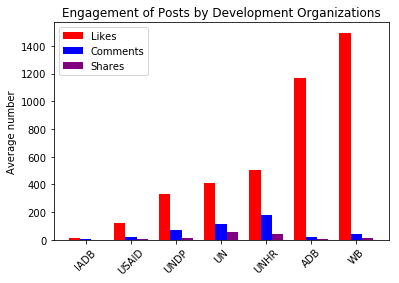

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

maporgnames = {'AsianDevBank': 'ADB',
              'IADB.org': 'IADB',
              'UNDP':'UNDP',
              'USAID':'USAID',
              'unitednations':'UN',
              'unitednationshumanrights':'UNHR',
              'worldbank':'WB'
             }

summarydata['newnames'] = list(map(maporgnames.get,summarydata['Page']))
summarydata.sort_values('Mean likes',inplace=True)
fig, ax = plt.subplots()
ax.set_ylabel('Average number')
ax.set_title('Engagement of Posts by Development Organizations')
ind = np.arange(len(summarydata))  # the x locations for the groups
width = 0.25       # the width of the bars
rects1 = ax.bar(ind, summarydata['Mean likes'], width, color='r')
rects2 = ax.bar(ind + width, summarydata['Mean shares'], width, color='b')
rects3 = ax.bar(ind + 2*width, summarydata['Mean comments'], width, color='purple')
ax.set_xticks(ind + width)
ax.set_xticklabels(summarydata['newnames'],rotation=45)
ax.legend((rects1[0], rects2[0], rects3[0]), ('Likes', 'Comments', 'Shares'), loc=2)

## Social media production:  posting frequency and content 

The international organizations reviewed are making efforts to leverage social media and keep users engaged by posting on averaging more than one post per day with UNDP making 2.3 posts on average per day.  Pictures and videos that can add value to posted messages are used frequently by the UN and World Bank with around half of all posts containing photos and UNHR using photos nearly 3/4 of the time.  Videos are used far less frequently with the UN using this type of media the most frequently out of the reviewed organizations at 18 percent.  Messages generally tend to be framed more positively than negatively as observed by the positive value on polarity.  Most posted messages are more objectively framed with statistical facts and figures as the average subjectivity of posts are closer to 0 than 1.  World Bank and ADB tend to focus the most on poverty and inequality in their posts at 30 percent and 18 percent respectively.  UNHR and the UN have a greater focus on corruption and governance accounting between 15-19 percent of all of their posts.

While UN, UNHR and World Bank have a high number of fans/followers of the pages at over 2 million the conversion of fans into actual engagement is low with the UN and UNHR receiving only about 400-500 likes per average while the World Bank receives 1500 likes per post.  However, the ADB has the highest likes per number of followers given that it only has around 250K follower, but nearly 1100 likes per post.  If comments and shares is a better measure of true engagement then both the UN is doing the best of the organizations reaching an average of 50 comments compared to only 3 comments on ADB pages and 15 comments on World Bank pages.  The UN organizations the UNHR also has nearly 4 times as many shares as the World Bank at 170 shares on average per post.  Nevertheless some of these basic statistics should be viewed with caution as a closer examination of World Bank and ADB page likes over time indicates that these likes may not be organic.  In contrast, comments and shares appear to suffer less from distortions.   


In [141]:
maporgnames = {'AsianDevBank': 'ADB',
              'IADB.org': 'IADB',
              'UNDP':'UNDP',
              'USAID':'USAID',
              'unitednations':'UN',
              'unitednationshumanrights':'UNHR',
              'worldbank':'WB'
             }

def likes_to_comments(mapdefdata):
    mean_ratio = {}
    mean_high_ratio = {}
    for key, data in mapdefdata.items():
        data["ratio_likes_comments"]=data['num_likes']/data['num_comments']
        data = data.loc[data["num_comments"]>0]
        mean_ratio[key] = data["ratio_likes_comments"].mean()
        #temp = data[data["ratio_likes_comments"] > 100]
        #print(key, temp['publish_year'].value_counts())
        
    sorted_ratio = sorted(mean_ratio, key=mean_ratio.get)
    sorted_ratio_names = list(map(maporgnames.get,sorted_ratio))
    sorted_ratio_values = [mean_ratio[s] for s in sorted_ratio]
    #print(sorted_ratio)
    #print(sorted_ratio_values)
    colorvals = []
    for s in sorted_ratio_values:
        if s >= 100:
            colorvals.append('red')
        elif s >= 50:
            colorvals.append('purple')
        else:
            colorvals.append('blue')
            
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.bar(range(len(sorted_ratio)), sorted_ratio_values, color=colorvals, align="center")
    ax.set_ylabel('Ratio')
    ax.set_title('Ratio of Likes to Comments')
    ax.set_xticks(ind)
    ax.set_xticklabels(sorted_ratio_names,rotation=45)
    ax.set_ylim(0,500)
    
    rects = ax.patches
    for rect, label in zip(rects, sorted_ratio_values):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, str(round(label,1)), ha='center', va='bottom', color='black', fontweight='regular')

    plt.show()

AsianDevBank 2016    317
2017    189
2015    119
2013      9
2012      3
Name: publish_year, dtype: int64
IADB.org 2014    10
2015     2
2016     1
Name: publish_year, dtype: int64
UNDP 2015    89
2016    18
2014     8
2012     3
2017     2
Name: publish_year, dtype: int64
unitednations Series([], Name: publish_year, dtype: int64)
unitednationshumanrights Series([], Name: publish_year, dtype: int64)
USAID 2017    26
2013    19
2016     9
2014     6
2011     4
2015     2
2012     2
Name: publish_year, dtype: int64
worldbank 2016    316
2017    235
2015     70
2014     54
2013      2
Name: publish_year, dtype: int64


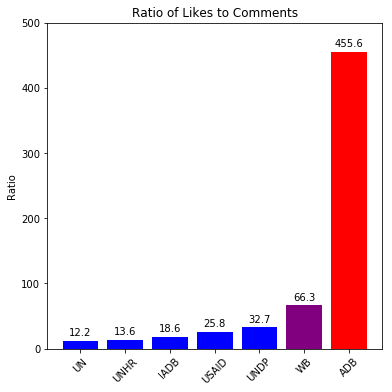

In [142]:
likes_to_comments(mapdefdata)

## The Problem of Fake Likes

One of the key concerns is that engagement may be superficial if organizations undertake actions to boost their engagement numbers.  The publicly available Facebook data, however, is somewhat limited in its scope to identify fake likes as it is not possible to break down likes by countries, languages or view details on most people who like the page beyond the ID/name.  This would present difficulties in the analysis in that it introduces an additional error into any model that attempts to understand factors driving engagement as it is unrelated to actual content of the post.

Considering that comments are a better measure of real engagement compared to likes as it involves an extra time cost we examine how the organizations compare in terms of the ratio of likes to comments.  All observations where comments are 0 are dropped from consideration.  The graph below shows that ADB stands out with nearly 455 times the number of likes compared to comments.  Nevertheless, World Bank has a comparatively high number of likes to comments at around 65 in comparison to some of the other organizations that have ratios of 30 or less.  This indicates the possibility that some organizations are undertaking superficial actions to artificially boost their ranking and number of likes their posts receive.  While it can be important for organizations to develop effective outreach strategies and conduct some advertising to garner support and highlight important issues, artificially boosting the number of likes may have very little return in developing true engagement. 


In [14]:
#Relevant plots across

%matplotlib inline
import matplotlib.pyplot as plt


mapcolors = { 'AsianDevBank': 'blue',
          'IADB.org': 'red',
          #'UNDP': 'green',
          'unitednations': 'orange',
          'unitednationshumanrights': 'pink',
          'USAID': 'purple',
          'worldbank': 'green'
}


def graph_data(mapdef):
    pages = ['AsianDevBank','unitednations','worldbank']
    for v in ['post','num_likes','num_shares','num_comments']:
        #initial set-up of the graphs
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel("Date")
        for key, val in mapdef.items():
            if key in pages:
                temp = val[[v,"status_published","publish_year"]]
                temp["date"] = [datetime.datetime(row.year,row.month,1) for row in temp["status_published"]]
                if v in ['post']:
                    average_month = temp.groupby("date").sum()
                    maintitle = "Number " + v + " Per Month"
                else:
                    average_month = temp.groupby("date").mean()
                    maintitle = "Average " + v + " Per Month"
            
                # reset the index so that the date is it's own variable
                average_month.reset_index(level=0, inplace=True)
                ax.plot(average_month['date'], average_month[v], c=mapcolors[key], label='Date', linewidth=2)
        #print(ax.get_xticklabels())
        #ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)
        plt.setp(ax.get_xticklabels(), visible=True)
        ax.set_ylabel(v)
        ax.set_title(maintitle)
        ax.legend(pages)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


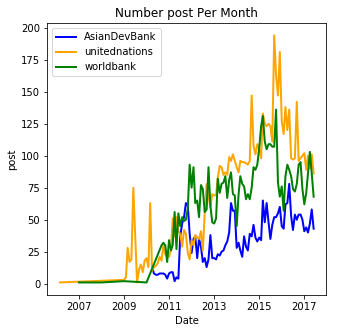

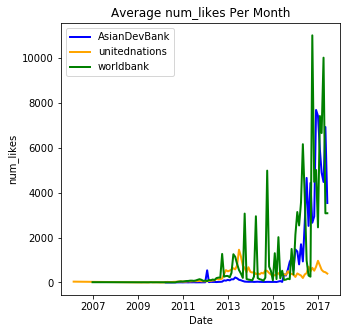

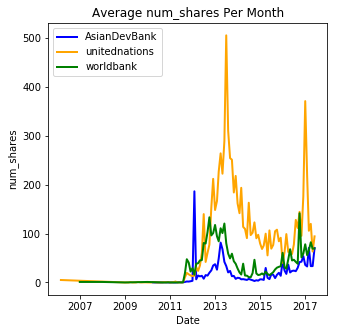

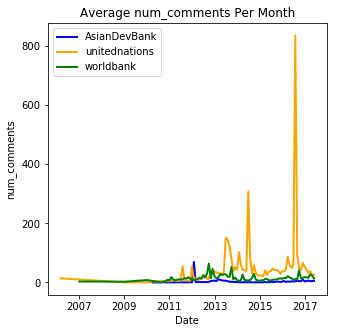

In [15]:
#print(mapdefdata.keys())
graph_data(mapdefdata)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def identify_correlations(data):
    data.corr()
    xcols = ["lnum_likes","photo","video","llen_message","positive_polarity","negative_polarity","message_subjectivity","llast_post_hrs",
         "num_post_L24hrs","num_post_L7days","num_post_L30days",
         "avg_num_likes_L7days","avg_num_likes_L30days","avg_num_shares_L7days","avg_num_shares_L30days","avg_num_comments_L7days","avg_num_comments_L30days"]

    temp = data[xcols]
    corr = temp.corr(method="pearson")

    #Examine variables highly correlated with log error (there is none b/c model is quite fit -- so question is can we find additional?)
    corr_y_high = []
    for col in corr.columns:
        if col != "lnum_likes" and abs(corr["lnum_likes"][col]) >= 0.1:
            corr_y_high.append(col)
    print(corr_y_high)
    
    temp = wbdata[xcols]
    corr = temp.corr(method="pearson")
    multicollinearity = []
    for i, col in enumerate(corr.columns):
        for j in range(i+1,len(corr.columns)):
            if i != j:
                if abs(corr[col][corr.columns[j]]) > 0.5:
                    multicollinearity.append([col,corr.columns[j],corr[col][corr.columns[j]]])
    #show all variables that have a high correlation with y
    print(multicollinearity)

In [235]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import math

def analyze_impact(data,num,show):
    
    train = data
    
    #add one to get eliminate problem of being undefined
    min_year = train['publish_year'].min()
    lhsvars = ["num_likes","num_comments","num_shares"]
    for v in lhsvars:
        train["l"+v] = np.log(train[v]+1)
    for v in ["len_message","last_post_hrs","avg_num_likes_L7days","avg_num_likes_L30days"]:
        train["l"+v] = np.log(train[v]+1)
    train['fhour']= (np.floor(train['publish_hour']/2)*2).astype(int)
    #print(train['fhour'].value_counts())
    train = pd.concat([train, pd.get_dummies(train["fhour"], prefix="hr")], axis=1)
    train = pd.concat([train, pd.get_dummies(train['day_of_week'], prefix="dow")], axis=1)
    train = pd.concat([train, pd.get_dummies(train['publish_year'], prefix="yr")], axis=1)
    train = pd.concat([train, pd.get_dummies(train['publish_month'], prefix="mt")], axis=1)   
    
    del train["yr_"+str(min_year)]
    del train["mt_1"]
    del train["dow_0"]
    del train["hr_0"]
    #del train["povertyineqgrowth"]
    
    print(train.shape)
    train["intercept"] = 1.0
    
    subcols = ['aid_effectiveness','climate_change','corruption_governance','data_technology','education','finance_investment',
           'gender','global_health','infrastructure','intltrade','migration','other']
    #Good to create asset values (or intensity of sharing over prior months)
    if num == 1 :
        xcols = ["photo","video","llen_message","positive_polarity","negative_polarity","message_subjectivity","llast_post_hrs",
                 "num_post_L30days"] + subcols
        #xcols.remove("povertyineqgrowth")
        train[xcols].to_csv('C:\\JobApplications\\Facebook\\regression_data.csv')
        train = train[train["num_post_L30days"].isnull()==False]
        #train = train[train["avg_num_comments_L30days"].isnull()==False]  #something wrong with how this data is constructed
    else:
        xcols = ["photo","video","llen_message","positive_polarity","negative_polarity","message_subjectivity","llast_post_hrs"]
        train = train[train["llast_post_hrs"].isnull()==False]
    for c in train.columns:
        if c.startswith("hr_",0) | c.startswith("yr_",0) | c.startswith("mt_",0) | c.startswith("dow_",0):
            xcols.append(c)

    dfresults = pd.DataFrame()
    dfresults['index']=['intercept']+xcols
    #print(len(xcols))
    #print(train.columns)
    for v in lhsvars:
        #robust covariance regressions corrected for serial correlation in errors
        xvars = '+'.join(xcols)
        lhsv = 'l'+v
        reg = smf.ols(lhsv +' ~ ' + xvars,data=train).fit()
        result = reg.get_robustcov_results(cov_type='HAC',maxlags=1)
        if show == 1:
            print(result.summary())
        #print(len(result.params))
        #print(xcols)
        #print(result.params)
        dfresults["Est"+v] = result.params
        #print(dfresults)
        dfresults['Pval'+v] = result.pvalues
        
    return(dfresults)

In [236]:
result = {}
#print(mapdefdata['AsianDevBank'].columns)
for w, data in mapdefdata.items():
    #print(w, mapdefdata[w].columns)
    result[w] = analyze_impact(mapdefdata[w],1,0)

(3033, 120)
(5123, 120)
(7084, 120)
(7322, 121)
(4591, 120)
(5534, 120)
(6006, 123)


In [237]:
# Automate the key factors resulting in more positive versus more negative impacts on likes, comments and re-shares
#result.sort_values('Estnum_likes',ascending=False,inplace=True)
#result.reset_index(inplace=True)
# Let us try to rank the change in coefficient estimates in terms of most important to least important factors
# Let us also try to output graphs that synthesize information easily. Note that it is best to standardize values
# Particularly ones that are not a 0-1 variable

def mapcolors(row):
    colors = []
    #print("ENTER")
    for v in row:
        if v <= 0.01:
            colors.append('blue')
        elif v <= 0.05:
            colors.append('mediumslateblue')
        elif v <= 0.1:
            colors.append('slateblue')
        else:
            colors.append('lightgrey')
    return(colors)

def graph_significance(result,pagename,data):

    lhs = ["num_likes","num_shares","num_comments"]
    result1 = result.round(3)
    result1.reset_index(inplace=True)
    #print(result1.round(3).head())

    for v in ['llen_message','llast_post_hrs','num_post_L30days']:
        #print(type(v))
        for l in lhs:
            result1.loc[result1['index'] == v,["Est"+l]]= result1.loc[result1['index'] == v,["Est"+l]]*data[v].std()

    #Create a mapping of data to enhance printing:
    mapnames = {}
    mname = ['January','February','March','April','May','June','July','August','September','October','November','December']
    downame = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
    for i in range(1,13):
        mapnames['mt_'+str(i)] = mname[i-1]
    for i in range(1,25):
        mapnames['hr_'+str(i)] = 'Hour '+str(i)
    for i in range(0,7):
        mapnames['dow_'+str(i)] = downame[i]
    
    xcols = ["photo","video","llen_message","positive_polarity","negative_polarity","message_subjectivity","llast_post_hrs",
             "num_post_L30days"]
    xnames = ["Photo","Video","Message Length (log)","Positive Polarity","Negative Polarity","Subjectivity","Hours Since Last Post (log)",
              "# of Posts (30 days)"]
    for i in range(0,len(xcols)):
        mapnames[xcols[i]] = xnames[i]
    subcols = ['aid_effectiveness','climate_change','corruption_governance','data_technology','education','finance_investment',
           'gender','global_health','infrastructure','intltrade','migration','other']
    subnames = ['Aid Effectiveness','Climate Change','Corruption & Governance','Data & Technology','Education','Finance & Investment',
           'Gender','Global Health','Infrastructure','International Trade','Migration','Other']
    for i in range(0,len(subcols)):
        mapnames[subcols[i]] = subnames[i]

    mapnames['num_likes'] = '# of Likes'
    mapnames['num_shares'] = '# of Shares'
    mapnames['num_comments'] = '# of Comments'
    result1['newnames'] = list(map(mapnames.get,result1['index']))
    result1.sort_values('Estnum_likes',inplace=True)

    #ax = plt.subplot(9, 9, 1)
    fig = plt.figure(figsize=(12, 16))
    fig.suptitle(pagename)
    result1['temp_yr'] = [row.find('yr') for row in result1['index']]
    result1['temp_hr'] = [row.find('hr') for row in result1['index']]
    result1['temp_mt'] = [row.find('mt') for row in result1['index']]
    result1['temp_dow'] = [row.find('dow') for row in result1['index']]
    result1['temp_sub'] = [0 if row in subcols else -1 for row in result1['index']]

    result1 = result1[(result1['temp_yr'] < 0) & (result1['index'] != 'intercept')]
    result1_hr = result1[(result1['temp_hr']==0)]
    result1_mt = result1[(result1['temp_mt']==0)]
    result1_sub = result1[(result1['temp_sub']==0)]
    result1_dow = result1[(result1['temp_dow']==0)]
    result1_other = result1[(result1['temp_hr']<0) & (result1['temp_mt']<0) & (result1['temp_dow']<0) & (result1['temp_sub']<0)]
    #result1_other.sort_values("Est"+l,ascending=False,inplace=True)

    #Plot for hourly data
    for i,l in enumerate(lhs):
        ax = fig.add_subplot(4,3,1+i)
        ax.set_title(mapnames[l])
        colorvals = mapcolors(result1_hr['Pval'+l])
        ax.barh(range(len(result1_hr)), result1_hr['Est'+l], color=colorvals, align="center")
        ax.set_yticks(range(len(result1_hr)))
        if i == 0:
            ax.set_yticklabels(result1_hr['newnames'])
        else:
            ax.tick_params(labelleft='off')
        if i == len(lhs)-1:
            ax.set_ylabel("Relative to Midnight")
            ax.yaxis.set_label_position("right")
        #ax.set_xlabel('Change in '+mapnames[l])
    for i,l in enumerate(lhs):
        #plt.show()
        #Plot for monthly data
        ax = fig.add_subplot(4,3,4+i)
        #ax.set_title(mapnames[l])
        colorvals = mapcolors(result1_dow['Pval'+l])
        ax.barh(range(len(result1_dow)), result1_dow['Est'+l], color=colorvals, align="center")
        ax.set_yticks(range(len(result1_dow)))
        if i == 0:
            ax.set_yticklabels(result1_dow['newnames'])
        else:
            ax.tick_params(labelleft='off')
        if i == len(lhs)-1:
            ax.set_ylabel("Relative to Sunday")
            ax.yaxis.set_label_position("right")
        #ax.set_xlabel('Change in '+mapnames[l])
    for i,l in enumerate(lhs):
        #Plot for other data
        ax = fig.add_subplot(4,3,7+i)
        #ax.set_title(mapnames[l])
        colorvals = mapcolors(result1_other['Pval'+l])
        ax.barh(range(len(result1_other)), result1_other['Est'+l], color=colorvals, align="center")
        ax.set_yticks(range(len(result1_other)))
        if i == 0:
            ax.set_yticklabels(result1_other['newnames'])
        else:
            ax.tick_params(labelleft='off')
        if i == len(lhs)-1:
            ax.set_ylabel("Relative to Various")
            ax.yaxis.set_label_position("right")
        #ax.set_xlabel('Change in '+mapnames[l])
    for i,l in enumerate(lhs):
        #Plot for other data
        ax = fig.add_subplot(4,3,10+i)
        #ax.set_title(mapnames[l])
        colorvals = mapcolors(result1_sub['Pval'+l])
        ax.barh(range(len(result1_sub)), result1_sub['Est'+l], color=colorvals, align="center")
        ax.set_yticks(range(len(result1_sub)))
        if i == 0:
            ax.set_yticklabels(result1_sub['newnames'])
        else:
            ax.tick_params(labelleft='off')
        if i == len(lhs)-1:
            ax.set_ylabel("Relative to Poverty & Inequality")
            ax.yaxis.set_label_position("right")
        ax.set_xlabel('Change in '+mapnames[l])

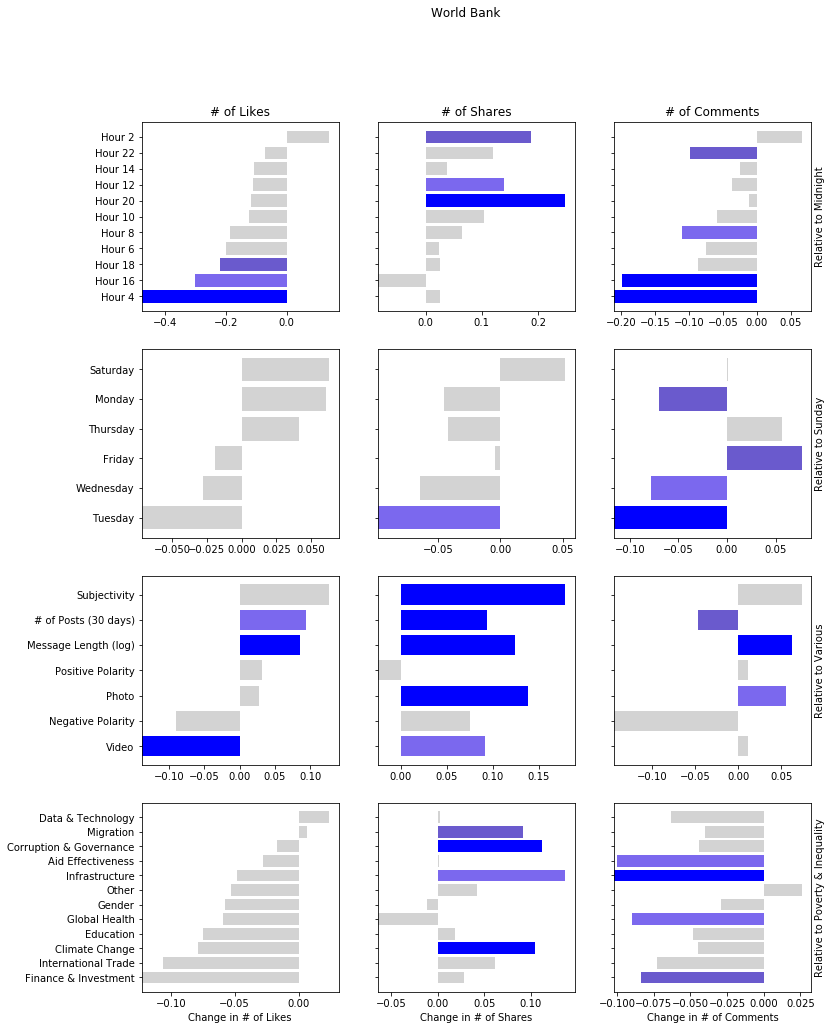

In [238]:
graph_significance(result['worldbank'],'World Bank',mapdefdata['worldbank'])

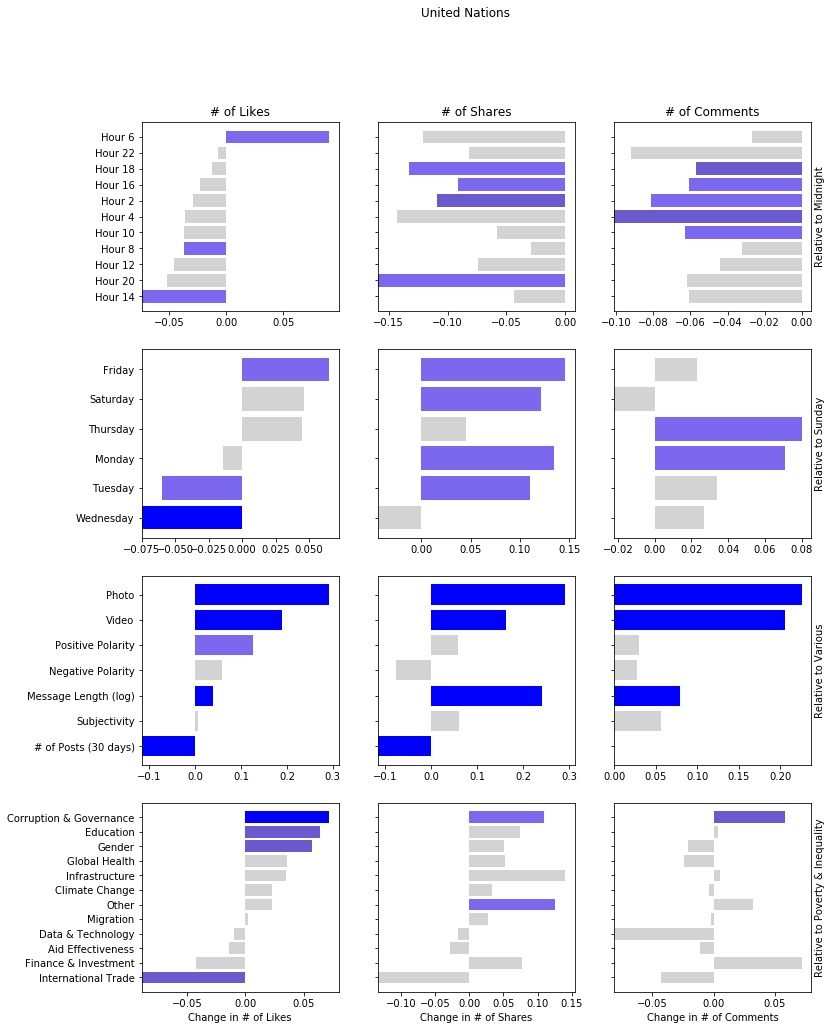

In [239]:
graph_significance(result['unitednations'],'United Nations',mapdefdata['unitednations'])

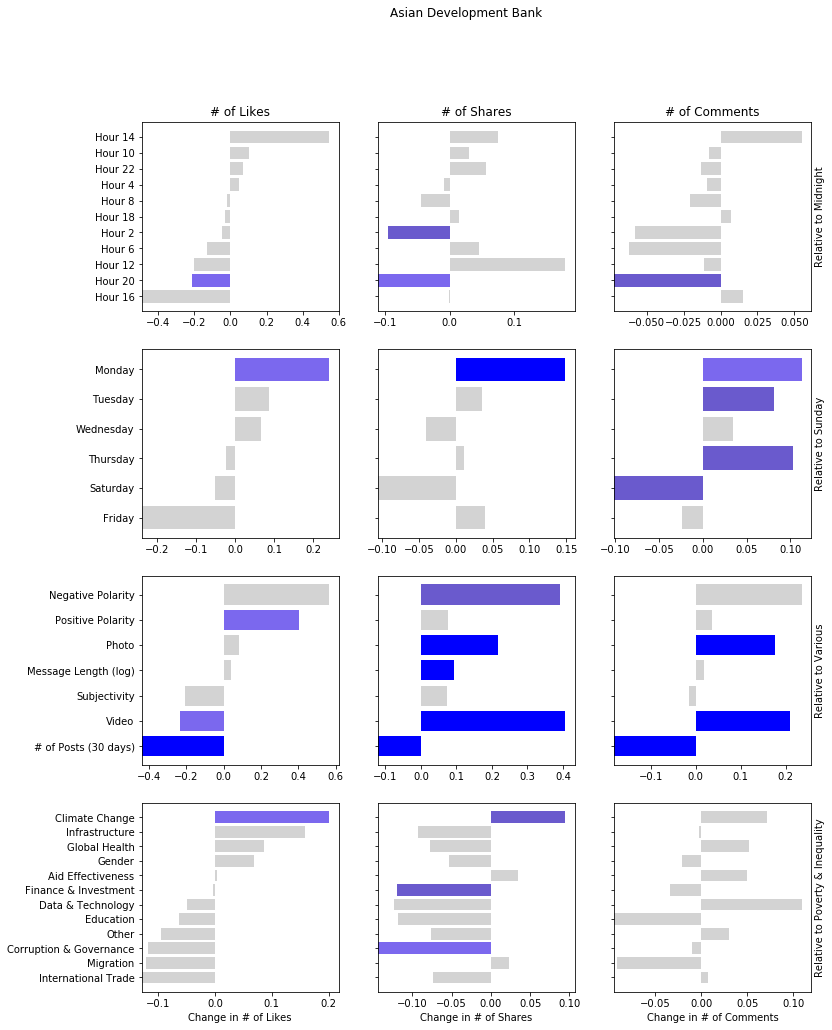

In [240]:
graph_significance(result['AsianDevBank'],'Asian Development Bank',mapdefdata['AsianDevBank'])

## Factors influencing engagement on Facebook

Regression estimation allows us to focus on different factors that influence engagement on Facebook.  While these factors are not considered causal within this framework they do provide a way to narrow down the set of strategies that could matter in increasing user engagement.  These linear regressions use robust standard errors that correct for serial correlation in errors over time that are related to trends in engagement.  

Broad findings:
1. Posts with photos typically are more effective in obtaining likes, comments, and shares compared to posts that do not.  They also are generally more effective than video potentially due to the hurdle (even if it is small one) of needing to watch the video.
2. Posting time does tend to matter in generating more likes, comments, and shares.  Posts that occur on Sunday/Monday generally tend to do better than those that occur on Friday or Saturday.
3. Posts with longer messages on average do increase likes and comments.  Whether this is related to quality of content or other factors is still unknown.
4. There are indications that the core followers of the organizations differ substantially in terms of their response rates to different content.  For the World Bank there is no difference in likes among the different topic postings, but topics of migration, corruption and governance, and infrastructure getting more shares.  The UN gets more likes on topics of corruption and governance, gender, and education.  ADB only receives positive responses to topics of climate change.

              l1_num_likes  num_likes
l1_num_likes      1.000000   0.460297
num_likes         0.460297   1.000000


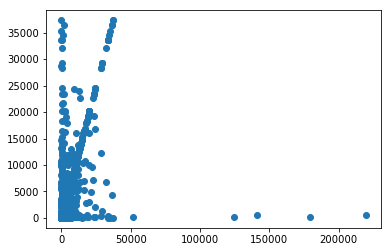

In [24]:
from pandas import Series
from matplotlib import pyplot as plt
from pandas.tools.plotting import lag_plot

#check for serial correlation by graphing scatter plot
wbdata = mapdefdata['worldbank']
wbdata['l1_num_likes'] = wbdata['num_likes'].shift(-1)
wbdata = wbdata.loc[wbdata['num_likes'] <= 50000]
plt.scatter(wbdata['l1_num_likes'],wbdata['num_likes'])
#plt.show()

# Check to see if there is possible serial correlation (0.46 means it could be moderate)
print(wbdata[['l1_num_likes','num_likes']].corr())


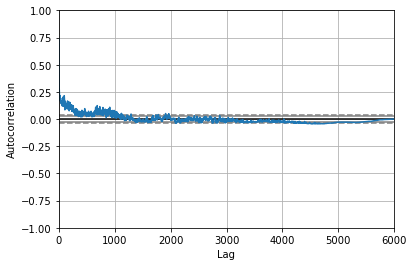

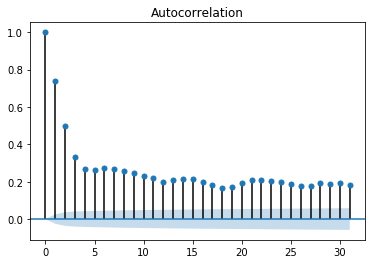

In [25]:
from pandas import Series
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(wbdata['num_likes'])
pyplot.show()

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(wbdata['num_likes'], lags=31)
pyplot.show()

#http://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

# Conclusions

The organizations considered have many differences in the frequency of posts, timing of posts, and the topic matter of the posts.  They also differ in strategies on using video and photo messaging.  We used a simple linear framework to analyze contributors to higher number of likes, comments, and shares. It was found that how people interact with the pages and what they respond to are different among the organizations suggesting differences in demographics and preferences of the consumers of the content of posts put out by these organizations.  However, when organizations potentially rely heavily on buying likes the content may matter very little in increasing real user engagement.  

## Improving identification

This is a first pass at trying to understand what drives user engagement in international organizations.  However, by gathering outside data on relevant and newsworthy topics it is possible to better understand the value added from strategic posting.  Being able to obtain more detailed data on who is liking, sharing and commenting on the pages can help to better design posting content that is targeted and different demographic groups and identify key influencers that can be leveraged to generate greater engagement.  Finally, being able to separate out artificial likes from real likes may be important step in trying to improving accountability and the content produced by these organizations that is responsive and more informative for the issues that followers are concerned about.  
